In [1]:
import sys
sys.path.append('/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/')

from src.GradShafranovCutFEM import *

### LOCATION OF FOLDERS
folder_MESHES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/MESHES/'   # MESHES
folder_CASES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/CASES/'     # CASES

### SELECT MESH FOLDER...
#MESH = 'TS-UNSTRUCTURED_ULTRACOARSE'
#MESH = 'TS-UNSTRUCTURED_COARSE'
#MESH = 'TS-UNSTRUCTURED_COARSE-FINE'
#MESH = 'TS-UNSTRUCTURED_FINE'
MESH = 'TS-UNSTRUCTURED_FINE_EXTENDED'
#MESH = 'TS-UNSTRUCTURED_ULTRAFINE'

# ... WITH MESH ELEMENTS: 
ElementType = 1     # Element type -> 1: TRIANGLE  ; 2: QUADRILATERAL
ElementOrder = 1    # Element order -> 1: LINEAR  ; 2: QUADRATIC ; 3: CUBIC ...

### SELECT SOLUTION CASE FILE:
## FIXED PLASMA BOUNDARY
#CASE = 'TS-FIXED-1W-LINEAR'          # FIXED PLASMA BOUNDARY WITH TOKAMAK FIRST WALL PLASMA REGION SHAPE AND LINEAR PLASMA CURRENT MODEL
#CASE = 'TS-FIXED-1W-NONLINEAR'       # FIXED PLASMA BOUNDARY WITH TOKAMAK FIRST WALL PLASMA REGION SHAPE AND NONLINEAR PLASMA CURRENT MODEL
#CASE = 'TS-FIXED-F4E-LINEAR'         # FIXED PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND LINEAR PLASMA CURRENT
#CASE = 'TS-FIXED-F4E-PROFILES'       # FIXED PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD
## FREE PLASMA BOUNDARY
#CASE = 'TS-FREE-F4E-LINEAR'          # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND LINEAR PLASMA CURRENT MODEL
#CASE = 'TS-FREE-F4E-NONLINEAR'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND NONLINEAR PLASMA CURRENT MODEL
CASE = 'TS-FREE-F4E-PROFILES'        # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD
#CASE = 'TS-FREE-F4E-LINEAR-1W'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, LINEAR PLASMA CURRENT AND FIRST WALL VACUUM VESSEL GEOMETRY  
#CASE = 'TS-FREE-F4E-PROFILES-1W'     # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD AND FIRST WALL VACUUM VESSEL GEOMETRY  

# SELECT ORDER OF NUMERICAL INTEGRATION QUADRATURE
QuadratureOrder = 2

##############################################################

# DECLARE OBJECT PROBLEM 
Problem = GradShafranovCutFEM(folder_MESHES+MESH,folder_CASES+CASE,ElementType,ElementOrder)
Problem.EQUILI()

READ INPUT FILES...
     -> READ MESH DATA FILES...Done!
     -> READ EQUILI DATA FILE...Done!
Done!
INITIALIZATION...
     -> INITIALISE LEVEL-SET...Done!
     -> INITIALISE ELEMENTS...Done!
     -> CLASSIFY ELEMENTS...Done!
     -> APPROXIMATE VACUUM VESSEL FIRST WALL...Done!
     -> APPROXIMATE PLASMA/VACUUM INTERFACE...Done!
     -> COMPUTE NUMERICAL INTEGRATION QUADRATURES...Done!
     -> INITIALISE UNKNOWN VECTORS AND COMPUTE INITIAL GUESS...
         -> COMPUTE INITIAL GUESS FOR PHI_NORM...Done!
         -> COMPUTE INITIAL VACUUM VESSEL FIRST WALL VALUES PHI_B...

KeyboardInterrupt: 

In [2]:
print(Problem.Elements[3398].Xe)

[[ 5.669873 -2.5     ]
 [ 5.669873 -2.75    ]
 [ 5.886379 -2.625   ]]


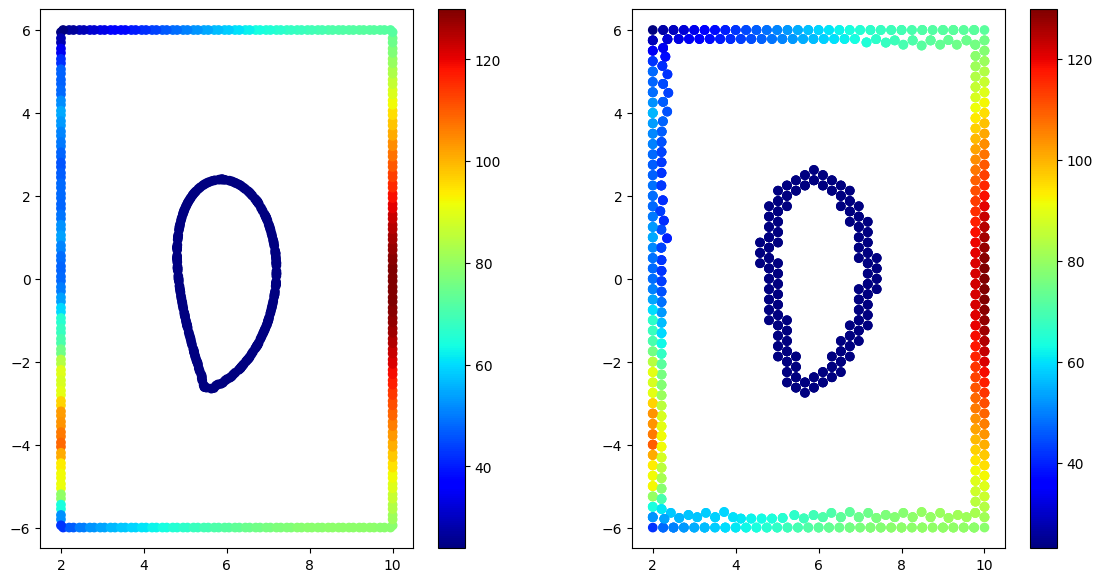

In [ ]:
Problem.PlotInterfaceValues()

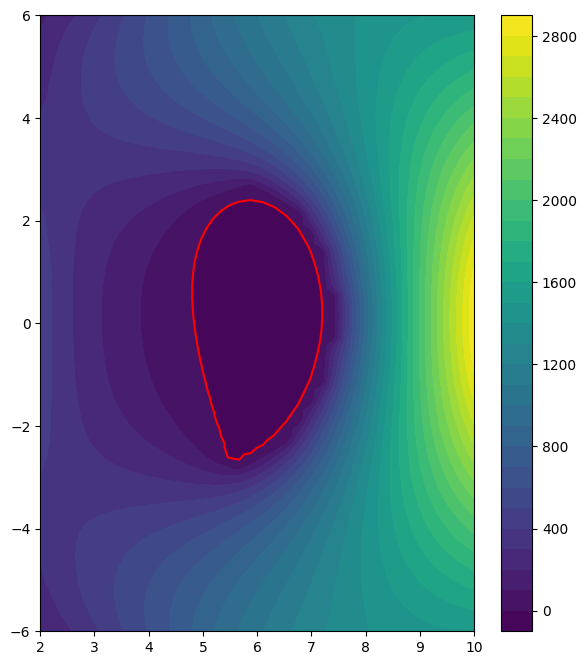

In [ ]:
Problem.PlotSolution(Problem.PHI)

In [ ]:
Problem.Xcrit

array([[ 6.0608,  0.2991,  1.    ],
       [ 2.333 , -3.4993, -1.    ]])

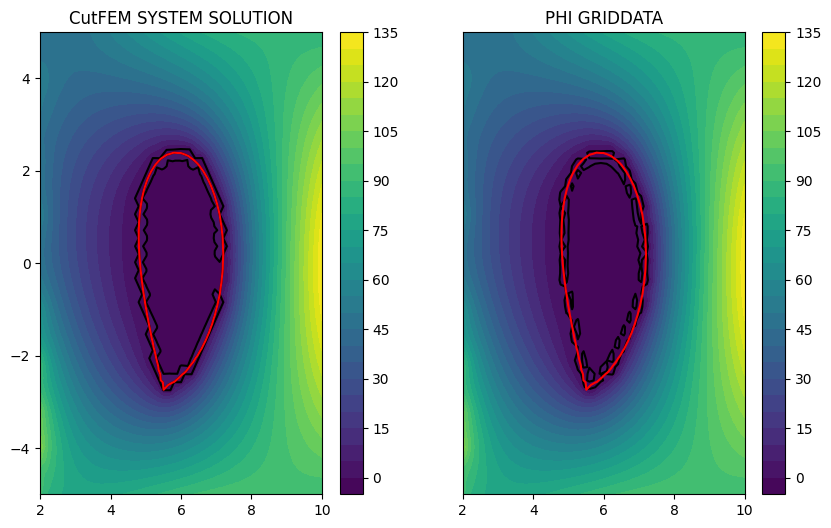

In [ ]:
self = Problem
PHI = self.PHI.T[0]

# 1. INTERPOLATE PHI VALUES ON A FINER STRUCTURED MESH USING PHI ON NODES
# DEFINE FINER STRUCTURED MESH
Mr = 50
Mz = 70
rfine = np.linspace(np.min(self.X[:,0]), np.max(self.X[:,0]), Mr)
zfine = np.linspace(np.min(self.X[:,1]), np.max(self.X[:,1]), Mz)
# INTERPOLATE PHI VALUES
Rfine, Zfine = np.meshgrid(rfine,zfine)
PHIfine = griddata((self.X[:,0],self.X[:,1]), PHI, (Rfine, Zfine), method='cubic')

# PLOT
fig, axs = plt.subplots(1, 2, figsize=(10,6))
for i in range(2):
    axs[i].set_xlim(self.Xmin, self.Xmax)
    axs[i].set_ylim(self.Ymin, self.Ymax)
# LEFT: PHI OBTAINED FROM SOLVING SYSTEM
a1 = axs[0].tricontourf(self.X[:,0],self.X[:,1],PHI, levels = 30)
axs[0].tricontour(self.X[:,0],self.X[:,1], PHI, levels=[0], colors = 'black')
axs[0].tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet, levels=[0], colors = 'red')
axs[0].set_title("CutFEM SYSTEM SOLUTION")
plt.colorbar(a1, ax=axs[0])
# RIGHT: PHI GRIDATTA 
a2 = axs[1].contourf(rfine,zfine,PHIfine,levels = 30)
axs[1].contour(rfine,zfine,PHIfine,levels = [0], colors = 'black')
axs[1].tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet, levels=[0], colors = 'red')
axs[1].set_title('PHI GRIDDATA')
axs[1].yaxis.set_visible(False)
plt.colorbar(a2, ax=axs[1])

[40, 18]


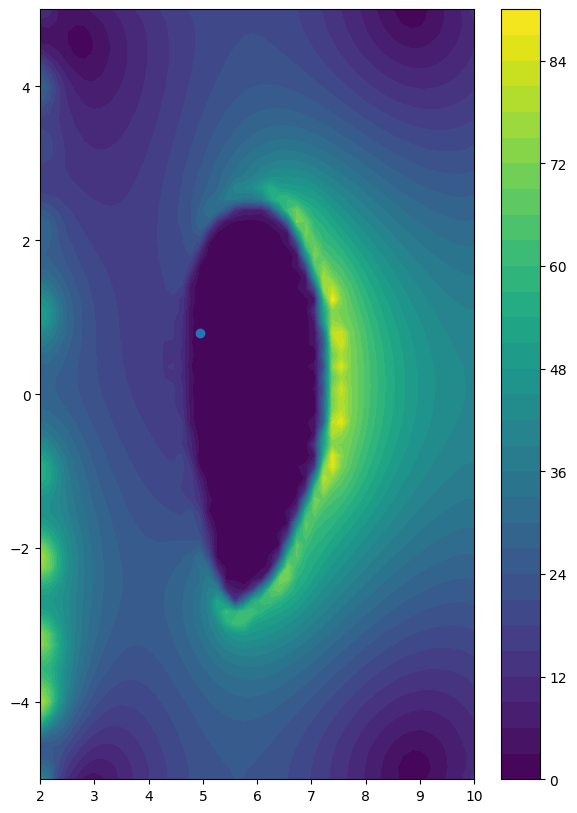

In [ ]:
# 2. COMPUTE GRAD(PHI) WITH FINER MESH VALUES USING FINITE DIFFERENCES
dr = (rfine[-1]-rfine[0])/Mr
dz = (zfine[-1]-zfine[0])/Mz
gradPHIfine = np.gradient(PHIfine,dr,dz)
NORMgradPHIfine = np.zeros(np.shape(gradPHIfine)[1:])
for i in range(Mr):
    for j in range(Mz):
        NORMgradPHIfine[j,i] = np.linalg.norm(np.array([gradPHIfine[0][j,i],gradPHIfine[1][j,i]]))

minpos = np.where(NORMgradPHIfine == np.min(NORMgradPHIfine))
minpos = [minpos[0][0],minpos[1][0]]

print(minpos)

plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine, levels=30)
plt.plot(rfine[minpos[1]],zfine[minpos[0]],'o')
plt.colorbar()

In [ ]:
def gradPHI(X,Rfine,Zfine,gradPHIfine):
    dPHIdr = griddata((Rfine.flatten(),Zfine.flatten()), gradPHIfine[0].flatten(), (X[0],X[1]), method='cubic')
    dPHIdz = griddata((Rfine.flatten(),Zfine.flatten()), gradPHIfine[1].flatten(), (X[0],X[1]), method='cubic')
    GRAD = np.array([dPHIdr,dPHIdz])
    return GRAD

"""X0 = np.array([6,0])
sol = optimize.root(gradPHI, X0, args=(Rfine,Zfine,gradPHIfine))
print(sol)

plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine,levels=30)
plt.plot(sol.x[0],sol.x[1],'o')
plt.colorbar()
"""

"X0 = np.array([6,0])\nsol = optimize.root(gradPHI, X0, args=(Rfine,Zfine,gradPHIfine))\nprint(sol)\n\nplt.figure(figsize=(7,10))\nplt.contourf(rfine,zfine,NORMgradPHIfine,levels=30)\nplt.plot(sol.x[0],sol.x[1],'o')\nplt.colorbar()\n"

In [ ]:
"""def gradient_descent(gradient, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine):
    Xk = np.zeros([itmax+1,2])
    it = 0; TOL = 1
    Xk[it,:] = X0
    while TOL > tolerance and it < itmax:
        dX = -alpha * gradient(Xk[it,:], Rfine,Zfine,gradPHIfine)
        Xk[it+1,:] = Xk[it,:]+np.flip(dX)
        TOL = np.linalg.norm(Xk[it+1,:]-Xk[it,:])
        it += 1
    return it, TOL, Xk[:it,:] 

X0 = np.array([6,2])
alpha = 1
itmax = 50; tolerance = 1e-5
it, TOL, Xk = gradient_descent(gradPHI, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine)

print(it, TOL)
print(Xk)

plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine,levels=50)
for i in range(it-1):
    plt.plot([Xk[i,0],Xk[i+1,0]],[Xk[i,1],Xk[i+1,1]],'-o')
plt.colorbar()"""

"def gradient_descent(gradient, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine):\n    Xk = np.zeros([itmax+1,2])\n    it = 0; TOL = 1\n    Xk[it,:] = X0\n    while TOL > tolerance and it < itmax:\n        dX = -alpha * gradient(Xk[it,:], Rfine,Zfine,gradPHIfine)\n        Xk[it+1,:] = Xk[it,:]+np.flip(dX)\n        TOL = np.linalg.norm(Xk[it+1,:]-Xk[it,:])\n        it += 1\n    return it, TOL, Xk[:it,:] \n\nX0 = np.array([6,2])\nalpha = 1\nitmax = 50; tolerance = 1e-5\nit, TOL, Xk = gradient_descent(gradPHI, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine)\n\nprint(it, TOL)\nprint(Xk)\n\nplt.figure(figsize=(7,10))\nplt.contourf(rfine,zfine,NORMgradPHIfine,levels=50)\nfor i in range(it-1):\n    plt.plot([Xk[i,0],Xk[i+1,0]],[Xk[i,1],Xk[i+1,1]],'-o')\nplt.colorbar()"

In [ ]:
Nr = 2
Nz = 2
# EXPLORATION ZONE 1 (LOOKING FOR MAGNETIC AXIS LOCAL EXTREMUM)
rA0 = np.linspace(self.R0-0.5,self.R0+0.5,Nr)
zA0 = np.linspace(-0.5,0.5,Nz)

# EXPLORATION ZONE 2 (LOOKING FOR SADDLE POINT)
rA1 = np.linspace(2.5,4.5,Nr)
zA1 = np.linspace(self.Ymin,self.Ymin+1,Nz)

Xcritvec = np.zeros([(Nr*Nz)*2,2])
i = 0
# EXPLORE ZONE 1
for r0 in rA0:
    for z0 in zA0:
        X0 = np.array([r0,z0])
        sol = optimize.root(gradPHI, X0, args=(Rfine,Zfine,gradPHIfine))
        if sol.success == True:
            Xcritvec[i,:] = sol.x
            i += 1
# EXPLOR ZONE 2
for r0 in rA1:
    for z0 in zA1:
        X0 = np.array([r0,z0])
        sol = optimize.root(gradPHI, X0, args=(Rfine,Zfine,gradPHIfine))
        if sol.success == True:
            Xcritvec[i,:] = sol.x
            i += 1
            
Xcritvec = Xcritvec[:i,:]

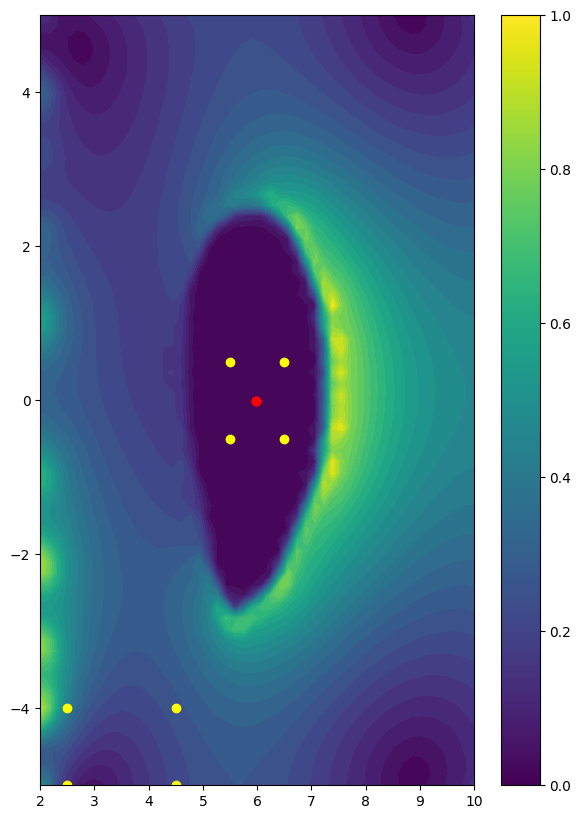

In [ ]:
plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine,levels=30)
for r0 in rA0:
    plt.scatter(r0*np.ones([Nz]),zA0,color ='yellow')
for r0 in rA1:
    plt.scatter(r0*np.ones([Nz]),zA1,color ='yellow')
plt.scatter(Xcritvec[:,0],Xcritvec[:,1],color='red')
plt.colorbar()
plt.show()

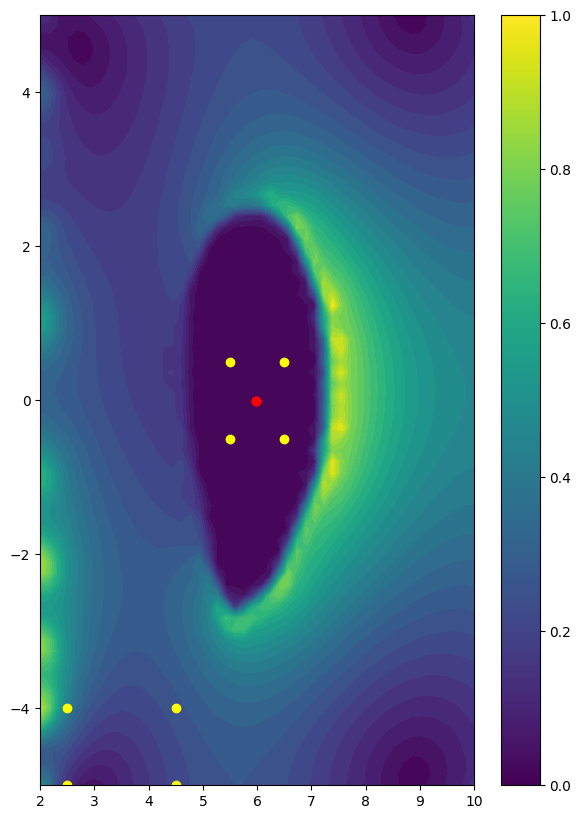

In [ ]:
# COMPUTE HESSIAN
def EvaluateHESSIAN(X,gradPHIfine,Rfine,Zfine,dr,dz):
    # compute second derivatives on fine mesh
    dgradPHIdrfine = np.gradient(gradPHIfine[0],dr,dz)
    dgradPHIdzfine = np.gradient(gradPHIfine[1],dr,dz)
    # interpolate HESSIAN components on point 
    dPHIdrdr = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdrfine[0].flatten(), (X[0],X[1]), method='cubic')
    dPHIdzdr = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdrfine[1].flatten(), (X[0],X[1]), method='cubic')
    dPHIdzdz = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdzfine[1].flatten(), (X[0],X[1]), method='cubic')
    if dPHIdrdr*dPHIdzdz-dPHIdzdr**2 > 0:
        return "Local extremum"
    else:
        return "Saddle point"
    
plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine,levels=30)
for r0 in rA0:
    plt.scatter(r0*np.ones([Nz]),zA0,color ='yellow')
for r0 in rA1:
    plt.scatter(r0*np.ones([Nz]),zA1,color ='yellow')
    
for i in range(len(Xcritvec[:,0])):
    nature = EvaluateHESSIAN(Xcritvec[i,:], gradPHIfine, Rfine, Zfine, dr, dz)
    if nature == "Local extremum":
        col = 'red'
    if nature == "Saddle point":
        col = 'orange'
    plt.plot(Xcritvec[i,0],Xcritvec[i,1],'o',color=col)
    
plt.colorbar()
plt.show()

In [ ]:
print(Xcritvec)

# Round each value in the array to the fourth decimal place
Xcritvec_rounded = np.round(Xcritvec, decimals=4)
# Convert each row to a tuple and create a set to remove duplicates
Xcritvec_final = {tuple(row) for row in Xcritvec_rounded}
# Convert the set back to a NumPy array
Xcritvec_final = np.array(list(Xcritvec_final))
# Caracterise critical point
Xcrit = np.zeros([len(Xcritvec_final[:,0]),3])
for i in range(len(Xcritvec_final[:,0])):
    Xcrit[i,:2] = Xcritvec_final[i,:]
    nature = EvaluateHESSIAN(Xcritvec_final[i,:], gradPHIfine, Rfine, Zfine, dr, dz)
    if nature == "Local extremum":
        Xcrit[i,-1] = 1
    elif nature == "Saddle point":
        Xcrit[i,-1] = -1

print(Xcrit)

[[ 5.9770492  -0.00888638]
 [ 5.9770492  -0.00888638]
 [ 5.9770492  -0.00888638]
 [ 5.9770492  -0.00888638]]
[[ 5.977  -0.0089  1.    ]]


In [ ]:
def SearchElement(Problem,X,elements):
    """ Function which finds the element among the elements list containing the point with coordinates X. """
    
    for elem in elements:
        Xe = Problem.Elements[elem].Xe
        # Calculate the cross products (c1, c2, c3) for the point relative to each edge of the triangle
        c1 = (Xe[1,0]-Xe[0,0])*(X[1]-Xe[0,1])-(Xe[1,1]-Xe[0,1])*(X[0]-Xe[0,0])
        c2 = (Xe[2,0]-Xe[1,0])*(X[1]-Xe[1,1])-(Xe[2,1]-Xe[1,1])*(X[0]-Xe[1,0])
        c3 = (Xe[0,0]-Xe[2,0])*(X[1]-Xe[2,1])-(Xe[0,1]-Xe[2,1])*(X[0]-Xe[2,0])
        if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
            break
    return elem

def InterpolateShapeFunctions(X,Xe,Fe,ElementType, ElementOrder):
    """ Interpolate field F on point X using shape functions in element with nodal coordinates Xe. """
    F = 0
    for i in range(len(Xe[:,0])):
        N = ShapeFunctionsPhysical(X, Xe, ElementType, ElementOrder, i+1)
        F += N*Fe[i]
    return F

for i in range(len(Xcrit[:,0])):
    elem = SearchElement(Problem,Xcrit[i,:2],np.concatenate((Problem.PlasmaElems,Problem.VacuumElems,Problem.VacVessWallElems),axis=0))
    ELEMENT = self.Elements[elem]
    # INTERPOLATE PHI VALUE ON CRITICAL POINT
    if Xcrit[i,-1] == 1:  # LOCAL EXTREMUM
        PHI_0 = InterpolateShapeFunctions(Xcrit[i,:2],ELEMENT.Xe,PHI[ELEMENT.Te],ELEMENT.ElType, ELEMENT.ElOrder)
    elif Xcrit[i,-1] == -1:   # SADDLE POINT
        PHI_X = InterpolateShapeFunctions(Xcrit[i,:2],ELEMENT.Xe,PHI[ELEMENT.Te],ELEMENT.ElType, ELEMENT.ElOrder) 

print(PHI_0)
print(PHI_X)

-0.8994534223920316
89.74767584676079


ValueError: z array must have same length as triangulation x and y arrays

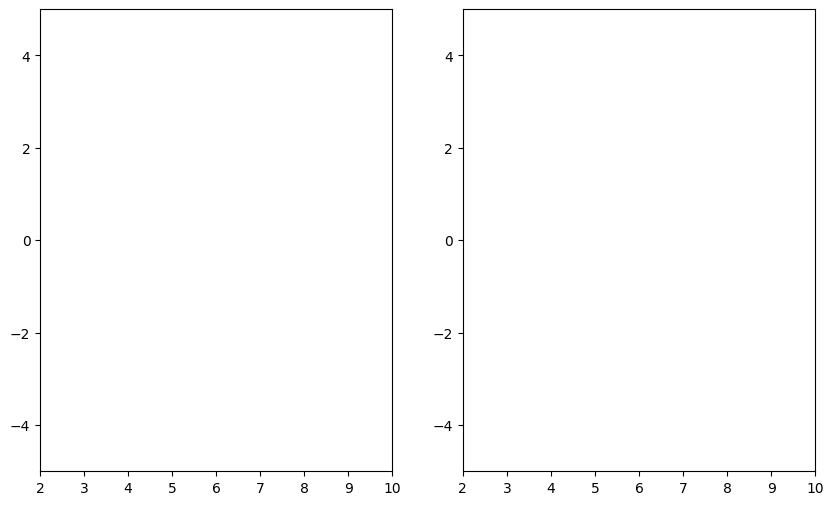

In [ ]:
# NORMALISATION
PHIbar = np.zeros([self.Nn])
for i in range(self.Nn):
    PHIbar[i] = (PHI[i]-PHI_X)/np.abs(PHI_0-PHI_X)
    
# PLOT
fig, axs = plt.subplots(1, 2, figsize=(10,6))
for i in range(2):
    axs[i].set_xlim(self.Xmin, self.Xmax)
    axs[i].set_ylim(self.Ymin, self.Ymax)
# LEFT: PHI OBTAINED FROM SOLVING SYSTEM
a1 = axs[0].tricontourf(self.X[:,0],self.X[:,1],PHI.T[0], levels = 30)
axs[0].tricontour(self.X[:,0],self.X[:,1], PHI.T[0], levels=[0], colors = 'black')
axs[0].tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet, levels=[0], colors = 'red')
axs[0].set_title("CutFEM SYSTEM SOLUTION")
plt.colorbar(a1, ax=axs[0])
# RIGHT: PHI GRIDATTA 
a2 = axs[1].tricontourf(self.X[:,0],self.X[:,1],PHIbar,levels = 30)
axs[1].tricontour(self.X[:,0],self.X[:,1],PHIbar,levels = [0], colors = 'black')
axs[1].tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet, levels=[0], colors = 'red')
axs[1].set_title('PHI GRIDDATA')
axs[1].yaxis.set_visible(False)
plt.colorbar(a2, ax=axs[1])

In [ ]:
PHI = self.PHI
PHI_0, PHI_X = self.ComputeCriticalPHI(PHI)
print(PHI_0, PHI_X)

5.9896770913033155 0.23097910085771847


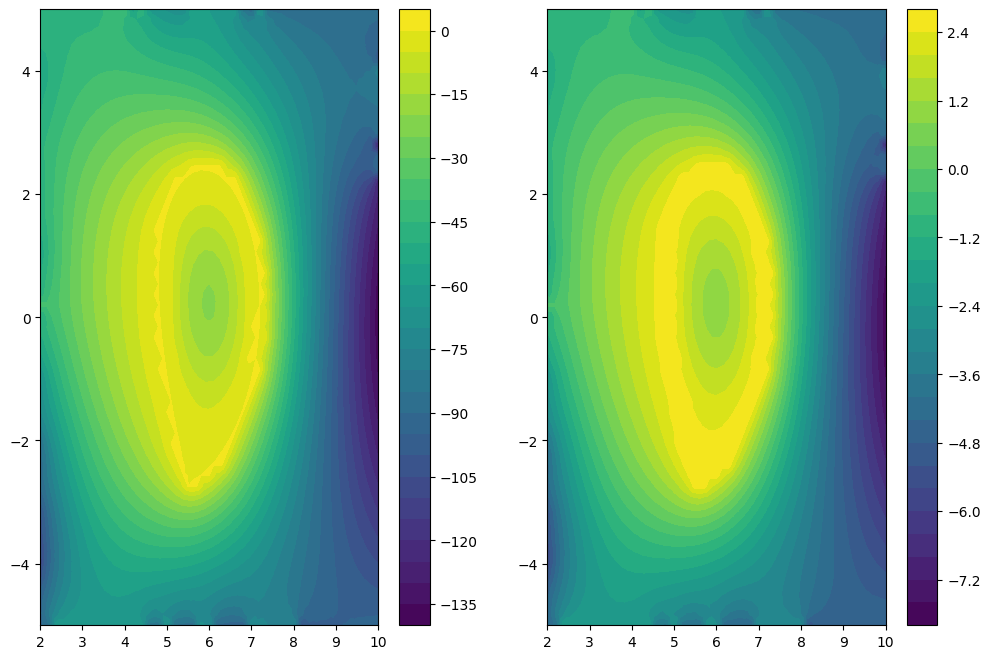

In [ ]:
#PHIbar = self.NormalisePHI(PHI,PHI_0,PHI_X)

PHIbar = np.zeros([self.Nn])
for i in range(self.Nn):
    PHIbar[i] = (PHI[i]-PHI_X)/np.abs(PHI_0-PHI_X)
        

fig, axs = plt.subplots(1, 2, figsize=(12,8))
a0 = axs[0].tricontourf(self.X[:,0],self.X[:,1],PHI.T[0],levels=30)
plt.colorbar(a0, ax=axs[0])

a1 = axs[1].tricontourf(self.X[:,0],self.X[:,1],PHIbar,levels=30)
plt.colorbar(a1, ax=axs[1])




In [ ]:
"""
fig, axs = plt.subplots(2, 3, figsize=(14,8))

itlist = [0,1,2]
topsuplots = ['a)','c)','e)']
bottomsuplots = ['b)','d)','f)']

for i, it in enumerate(itlist):
    # UPPER ROW SUBPLOTS: MESH ELEMENTS CLASSIFICATION
    axs[0,i].set_ylim(self.Ymin-0.1,self.Ymax+0.1)
    axs[0,i].set_xlim(self.Xmin-0.1,self.Xmax+0.1)
    # PLOT ELEMENTS FOR EACH GROUP
    for elem, group in enumerate(self.ElementalGroups_ALL[:,it]):
        if group == -1:
            c = 'red'
        elif group == 0:
            c = 'gold'
        elif group == 1:
            c = 'gray'
        elif group == 2:
            c = 'cyan'
        elif group == 3:
            c = 'brown'
        ELEMENT = self.Elements[elem]
        Xe = np.zeros([ELEMENT.n+1,2])
        Xe[:-1,:] = ELEMENT.Xe
        Xe[-1,:] = ELEMENT.Xe[0,:]
        axs[0,i].plot(Xe[:,0], Xe[:,1], color='black', linewidth=1)
        axs[0,i].fill(Xe[:,0], Xe[:,1], color = c)
    # PLOT PLASMA/VACUUM INTERFACE
    axs[0,i].tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet_ALL[:,it], levels=[0], colors = 'green', linewidths=2.5)
    # SUBPLOT TITLES
    if it == 0:
        axs[0,i].set_title("Initial Guess")
    else:
        axs[0,i].set_title("Iteration "+str(it))
        
    axs[0,i].text(self.Xmin-0.5, self.Ymax+0.5, topsuplots[i])
    
    # LOWER ROW SUBPLOTS: NORMALISED SOLUTION PHI_NORM
    axs[1,i].set_xlim(self.Ymin,self.Ymax)
    axs[1,i].set_xlim(self.Xmin,self.Xmax)
    a = axs[1,i].tricontourf(self.X[:,0],self.X[:,1], self.PHI_NORM_ALL[:,it], levels=40)
    axs[1,i].tricontour(self.X[:,0],self.X[:,1], self.PHI_NORM_ALL[:,it], levels=[0], colors = 'black',linewidths=1.5)
    axs[1,i].tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet_ALL[:,it], levels=[0], colors = 'red',linewidths=2.5)
    plt.colorbar(a, ax=axs[1,i])
    ## PLOT LOCATION OF CRITICAL POINTS
    # LOCAL EXTREMUM
    axs[1,i].scatter(self.PHI_crit_ALL[0,1,it],self.PHI_crit_ALL[0,2,it],marker = 'x',color='red', s = 45, linewidths = 2,zorder=+1)
    # SADDLE POINT
    axs[1,i].scatter(self.PHI_crit_ALL[1,1,it],self.PHI_crit_ALL[1,2,it],marker = 'x',color='orange', s = 45, linewidths = 2, zorder=+1)
    
    axs[1,i].text(self.Xmin-0.5, self.Ymax+0.5, bottomsuplots[i])

for j in range(2):
    for i in range(1,3):
        axs[j,i].yaxis.set_visible(False)
        
plt.show()
"""

In [ ]:
"""
fig, axs = plt.subplots(1, 3, figsize=(14,4))

itlist = [0,1,2]
topsuplots = ['a)','b)','c)']

for i, it in enumerate(itlist):
    # LOWER ROW SUBPLOTS: NORMALISED SOLUTION PHI_NORM
    axs[i].set_xlim(self.Ymin,self.Ymax)
    axs[i].set_xlim(self.Xmin,self.Xmax)
    a = axs[i].tricontourf(self.X[:,0],self.X[:,1], self.PHI_NORM_ALL[:,it], levels=40)
    axs[i].tricontour(self.X[:,0],self.X[:,1], self.PHI_NORM_ALL[:,it], levels=[0], colors = 'black',linewidths=1.5)
    axs[i].tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet_ALL[:,it], levels=[0], colors = 'red',linewidths=2.5)
    plt.colorbar(a, ax=axs[i])
    ## PLOT LOCATION OF CRITICAL POINTS
    # LOCAL EXTREMUM
    axs[i].scatter(self.PHI_crit_ALL[0,1,it],self.PHI_crit_ALL[0,2,it],marker = 'x',color='red', s = 45, linewidths = 2,zorder=+1)
    # SADDLE POINT
    axs[i].scatter(self.PHI_crit_ALL[1,1,it],self.PHI_crit_ALL[1,2,it],marker = 'x',color='orange', s = 45, linewidths = 2, zorder=+1)
    
    axs[i].text(self.Xmin-0.5, self.Ymax+0.5, topsuplots[i])
    # SUBPLOT TITLES
    if it == 0:
        axs[i].set_title("Initial Guess")
    else:
        axs[i].set_title("Iteration "+str(it))

for i in range(1,3):
    axs[i].yaxis.set_visible(False)
        
plt.show()
"""